<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

<h2>Import dataset

In [2]:
df_data = pd.read_csv('HR_comma_sep.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploratioin

In [3]:
pd.options.display.max_columns=100
df_model.head()
# df_model.Stay

# for x in df_model.Stay:
#     if df_model.Stay[x] != 0:
#       print(df_model.Stay[x])
#     else:
#       message ="no employee stay find!";
#       print(message)
#       break;

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'promotion_last_5years'

In [5]:
#choose the treatment variable
target = "left"

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


<h2>Check N-uniques for non-categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [8]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
3,average_montly_hours,215
0,satisfaction_level,92
1,last_evaluation,65
4,time_spend_company,8
2,number_project,6
5,Work_accident,2
6,left,2
7,promotion_last_5years,2


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [9]:
#choose a column with hiearchy to be label encoded
cluster_cols=['average_montly_hours']

<h2>Check uniques for categorical data

In [10]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Department
sales 4140
accounting 767
hr 739
technical 2720
support 2229
management 630
IT 1227
product_mng 902
marketing 858
RandD 787

 salary
low 7316
medium 6446
high 1237


<h2>Replace Yes or No to 1 or 0

In [11]:
# df_model.Attrition.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
# df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

<h2>Rename Data

In [12]:
df_model[[treat,target]].head()

,promotion_last_5years,left
id,,
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


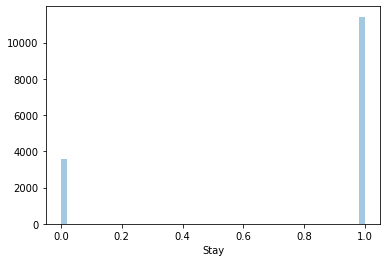

In [13]:
df_model = df_model.rename(columns={"left": "Stay"})
df_model.Stay = df_model.Stay.replace({0:1, 1:0})
sns.distplot(a=df_model.Stay, hist=True,kde=False)

<h2>Invert Target Value(Churn to Stay)

In [14]:
desc = pd.DataFrame()
desc['total N'] = [len(df_model)]
desc['total T'] = [sum(df_model[treat]==1)]
desc['total C'] = [sum(df_model[treat]==0)]
desc['total CR'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==1)]
desc['total CN'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==0)]
desc['total TR'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==1)]
desc['total TN'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==0)]
desc

,total N,total T,total C,total CR,total CN,total TR,total TN
0,14999,319,14680,10240,2384,36,307


In [15]:
# sns.distplot(a=df_model.Stay, hist=True,kde=False)

B.6. Inverting data from column 'Stay':[0 0 0 0 0 0 0 0 0 0] ... 
Inverted result named 'stay':[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] ... 
Column 'left' has been successfully replaced by new column 'stay'!


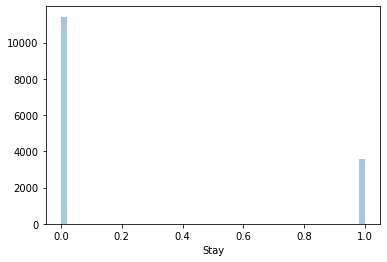

In [16]:
#setup the target column to be inverted and prepare empty array named inverted
input_data = df_model.Stay
inverted = []
print ("B.6. Inverting data from column '{}':{} ... ".format(input_data.name,df_model.Stay.values[:10]))

#inverting through all datas in column
for i in range(len(input_data)):
    inverted.append(1 - input_data[i])
print ("Inverted result named 'stay':{} ... ".format(inverted[:10]) )

#add new column stay and remove column left
df_model['Stay']=inverted
print ("Column 'left' has been successfully replaced by new column 'stay'!")

#check the result
sns.distplot(a=df_model.Stay, hist=True,kde=False)

In [17]:
desc = pd.DataFrame()
desc['total N'] = [len(df_model)]
desc['total C'] = [sum(df_model[treat]==0)]
desc['total T'] = [sum(df_model[treat]==1)]
desc['total CR'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==1)]
desc['total CN'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==0)]
desc['total TR'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==1)]
desc['total TN'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==0)]
desc

,total N,total C,total T,total CR,total CN,total TR,total TN
0,14999,14680,319,2384,10240,307,36


<h2>Define columns to Label encode

In [18]:
# df_model[object_cols].head()
df_model.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,Department,salary
id,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [19]:
#choose a column with wide range to be clusterred
label_cols = ['salary']

<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [20]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['salary']
>>label encoding finished


,salary
id,
0,1
1,2
2,2
3,1
4,1


<h2>Data cleaning

In [21]:
#DROP unused columns
# df_model = df_model.drop(['Over18','StandardHours','StockOptionLevel','EmployeeCount','EmployeeNumber'],axis=1)

<h2>Cluster & One Hot Encoding

In [22]:
#function to order clusters
# def order_cluster(cluster_field_name, target_field_name,df,ascending):
#     new_cluster_field_name = 'new_' + cluster_field_name
#     df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     df_new['index'] = df_new.index
#     df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
#     df_final = df_final.drop([cluster_field_name],axis=1)
#     df_final = df_final.rename(columns={"index":cluster_field_name})
#     return df_final

In [23]:
# #preparing float columns to cluster
# print('Clustering columns:',cluster_cols)
# #creating the clusters
# for col in cluster_cols:
#     col_cluster = col + "_cluster"
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(df_model[[col]])
#     df_model[col_cluster] = kmeans.predict(df_model[[col]])
#     #order the clusters
#     df_model = order_cluster(col_cluster, col, df_model, True)
# print('>>Cluster succeeded!')
# #dropping columns that have been clustered
# df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')


One Hot Encoding: ['satisfaction_level' 'last_evaluation' 'number_project'
 'average_montly_hours' 'time_spend_company' 'Work_accident' 'Stay'
 'promotion_last_5years' 'salary' 'Department_IT' 'Department_RandD'
 'Department_accounting' 'Department_hr' 'Department_management'
 'Department_marketing' 'Department_product_mng' 'Department_sales'
 'Department_support' 'Department_technical']
>>One Hot Encoding succeeded!


In [24]:
df_model

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
id,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,2,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,2,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


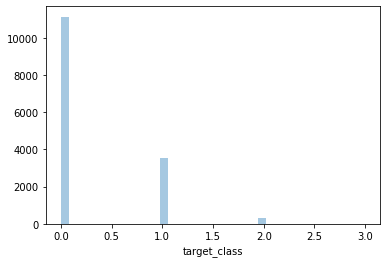

In [25]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Treatment Identification

In [26]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
pd.DataFrame(round(correlation.Stay.sort_values() * 100,2)).reset_index()

,index,Stay
0,satisfaction_level,-38.84
1,Work_accident,-15.46
2,promotion_last_5years,-6.18
3,Department_RandD,-4.66
4,Department_management,-4.60
5,Department_product_mng,-1.10
6,Department_IT,-1.09
7,salary,-0.13
8,Department_marketing,-0.09
9,last_evaluation,0.66


<Figure size 216x1440 with 0 Axes>

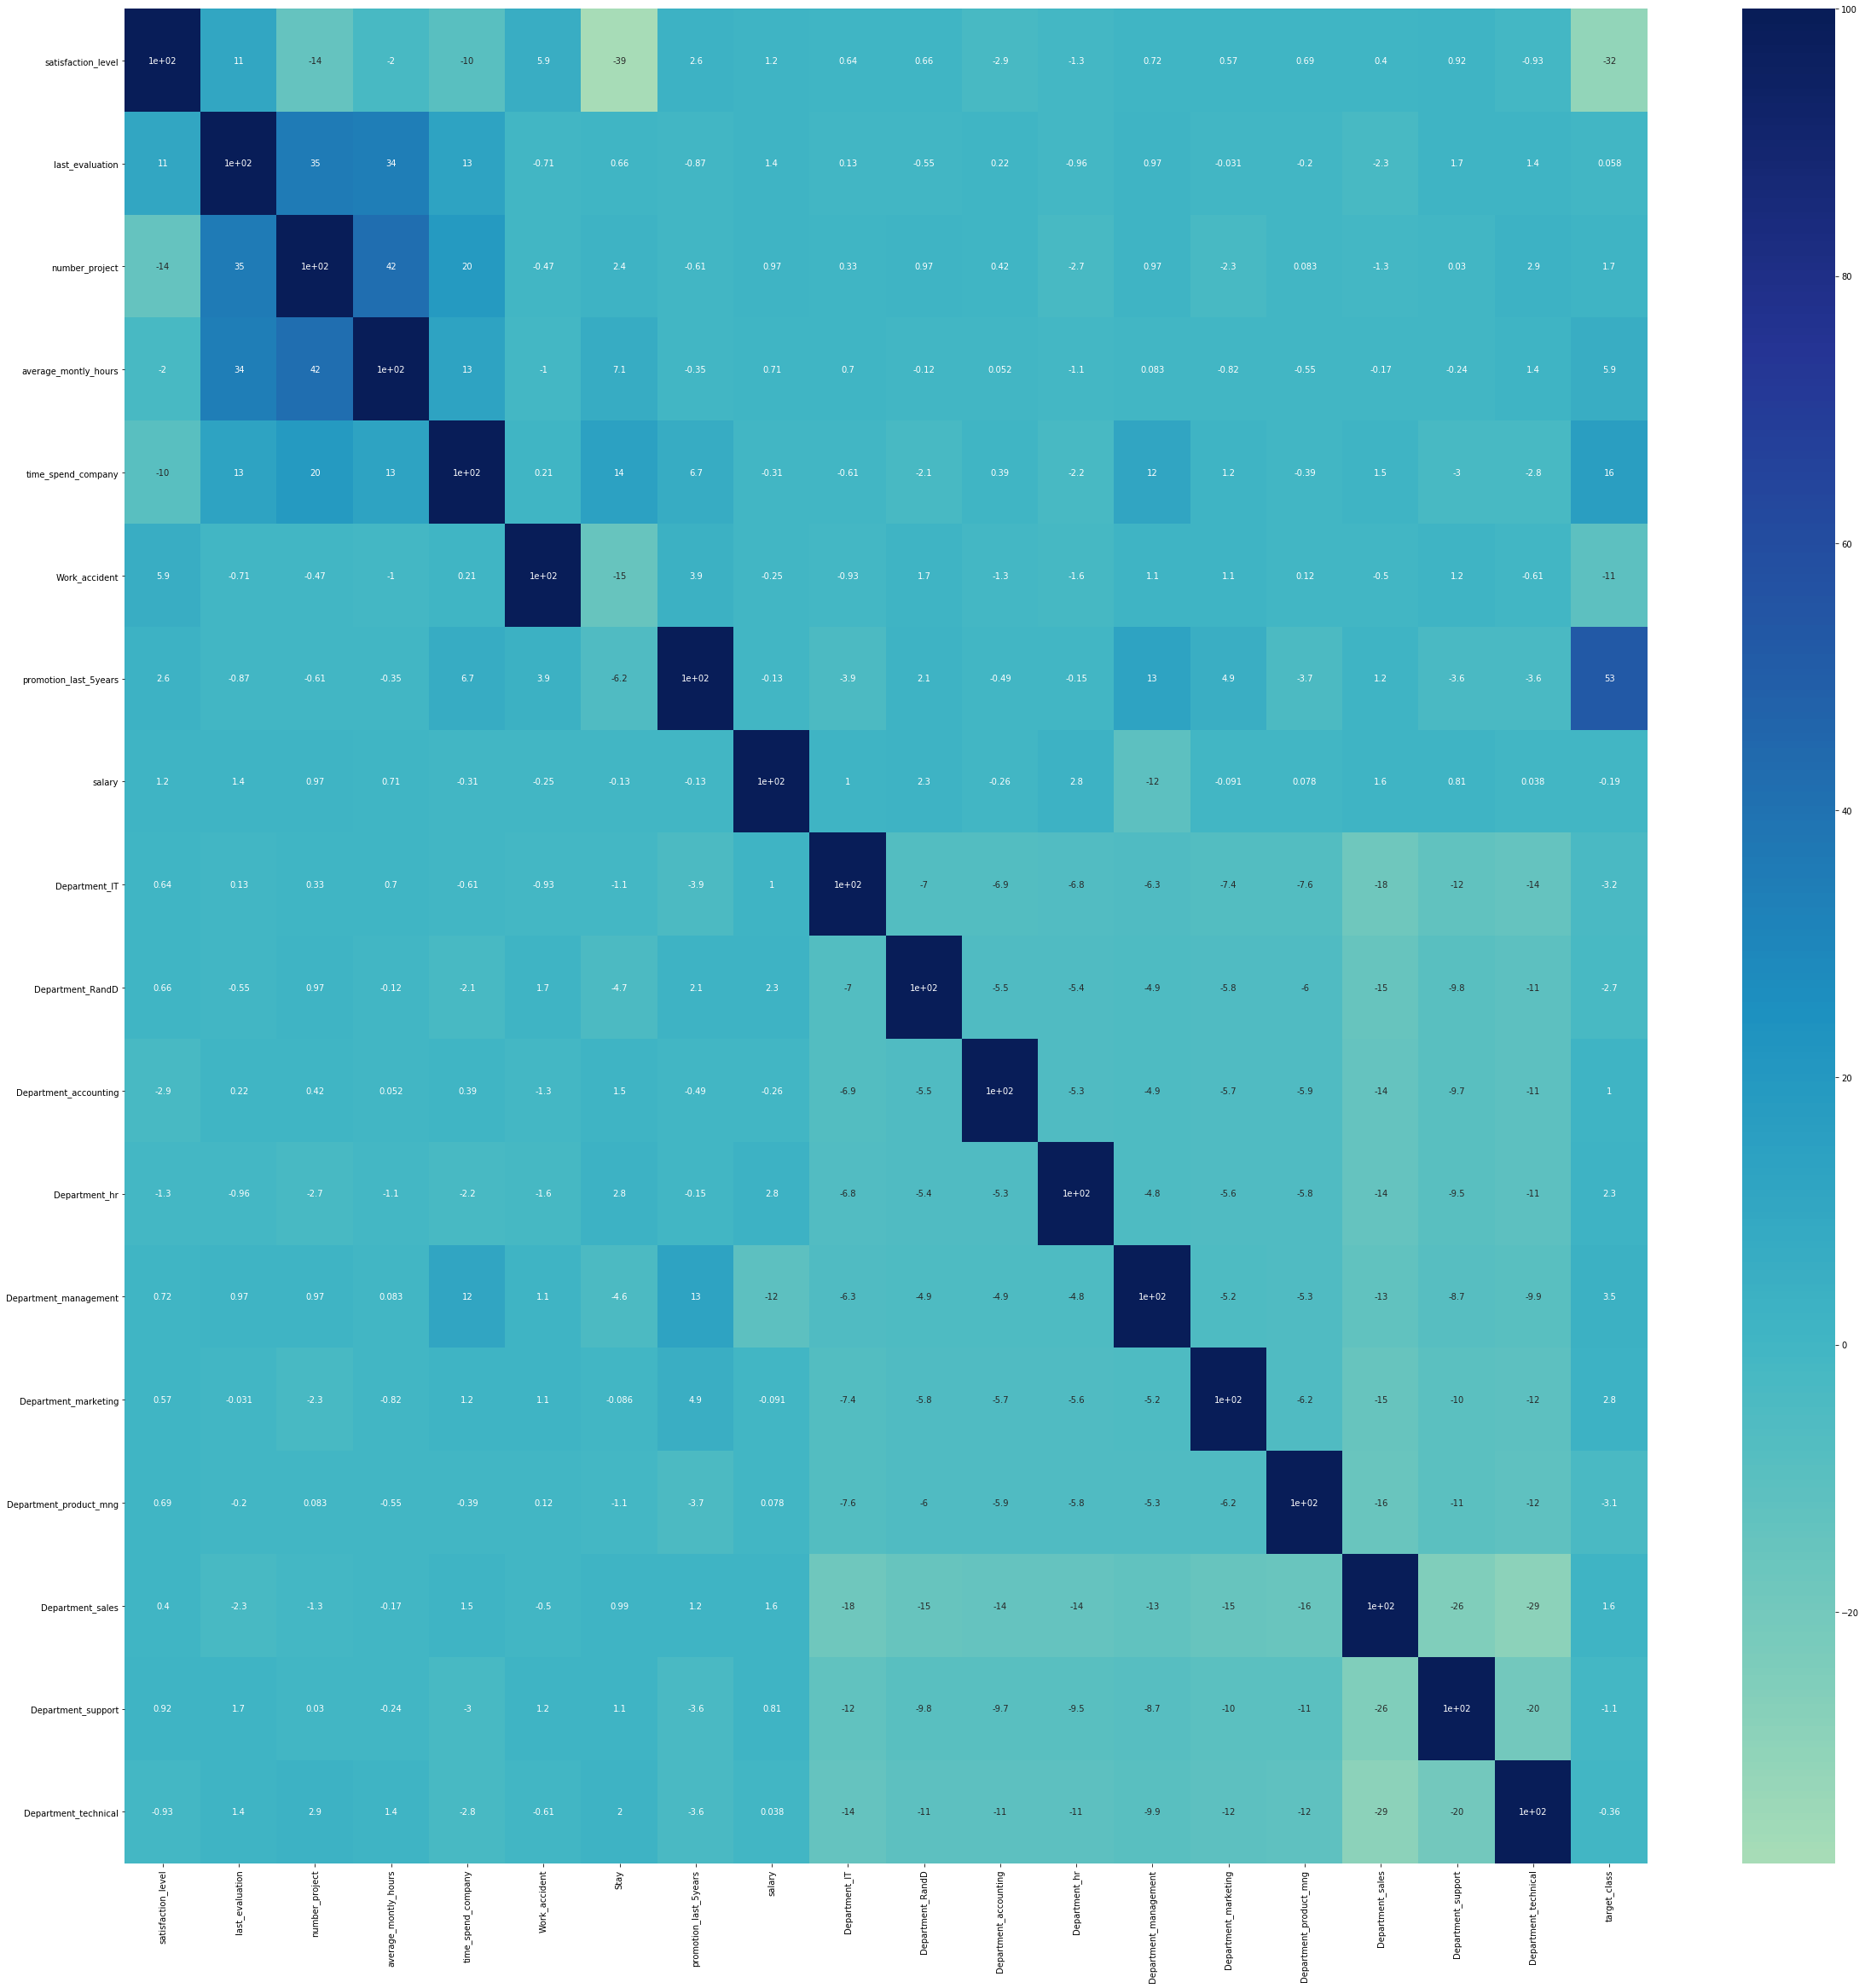

<Figure size 216x1440 with 0 Axes>

In [27]:
#measure the correlation of Employees who stay
treatment_corr_matrix = df_model.corr(method ='pearson')
#plot the data
plt.figure(figsize=(40,40))
corr = pd.DataFrame(treatment_corr_matrix.drop(labels=['Stay', 'target_class'])* 100)
sns.heatmap(corr, annot=True, center=0, cmap="YlGnBu")
plt.figure(figsize=(3,20))

In [28]:
treatment_corr_table = pd.DataFrame(treatment_corr_matrix['Stay'].drop(labels=['Stay', 'target_class']))
treatment_corr_table['target_class'] = pd.DataFrame(treatment_corr_matrix['target_class'].drop(labels=['Stay', 'target_class']))

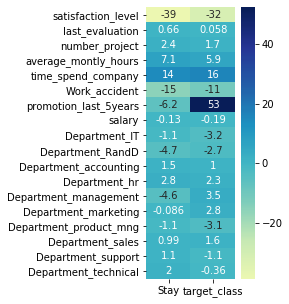

In [29]:
treatment_corr_table = pd.DataFrame(treatment_corr_matrix['Stay'].drop(labels=['Stay', 'target_class']))
treatment_corr_table['target_class'] = pd.DataFrame(treatment_corr_matrix['target_class'].drop(labels=['Stay', 'target_class']))
#plot features that correlated with stay and target class
plt.figure(figsize=(2,5))
sns.heatmap(treatment_corr_table*100, annot=True, center=0, cmap="YlGnBu")

Text(0.5, 1, 'Top 5 Correlation')

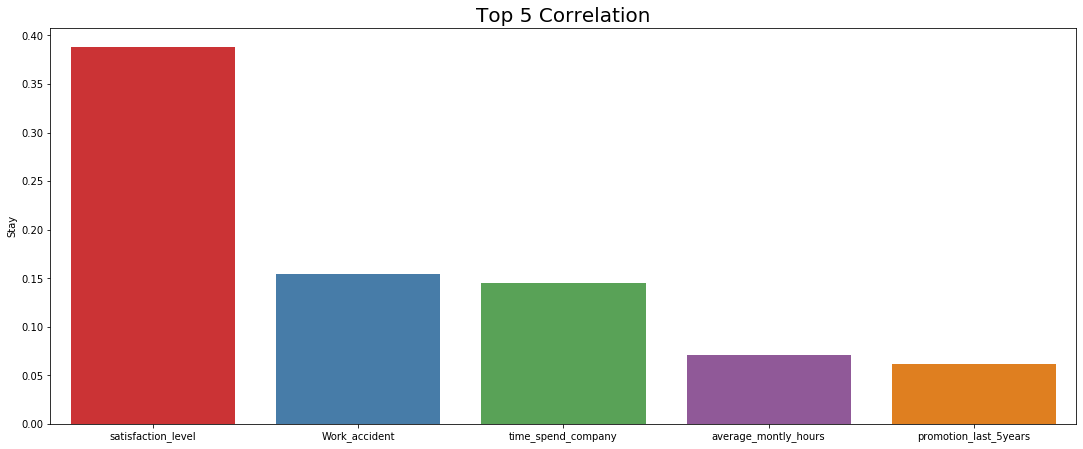

In [30]:
#define what column to drop
treat_matrix = treatment_corr_table.copy()
treat_matrix = treat_matrix.abs()*100 < 0
treat_matrix['and'] = treat_matrix.all(axis = 1)
target_labels = [treat, 'target_class','Stay']
#define what column to drop
drop_both = treat_matrix.index[treat_matrix['and'] == True].tolist()
drop_both.extend(target_labels)
drop_uplift = treat_matrix.index[treat_matrix['target_class'] == True].tolist()
drop_uplift.extend(target_labels)
drop_stay = treat_matrix.index[treat_matrix['Stay'] == True].tolist()
drop_stay.extend(target_labels)
# find the largest corr and plot it
largest_corr = treatment_corr_table.Stay.abs().nlargest(5)
largest = sns.barplot(y=largest_corr,x=largest_corr.index, palette='Set1')
plt.subplots_adjust(right=2.5)
plt.subplots_adjust(top=1.5)
plt.title('Top 5 Correlation',y=1, fontsize=20)

<h2>Create new dataframe for churn and uplift

In [31]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

    target_class  Stay  promotion_last_5years
id                                           
0              1     1                      0
1              1     1                      0
2              1     1                      0
3              1     1                      0
4              1     1                      0


<h1> Modeling

<h2> Set Labels

In [32]:
#create features
X = df_model
#create labels for churn target
y_stay = df_model.Stay
#create labels for treatment
t = df_model[treat]
#create labels
y_target_class = df_model.target_class

In [33]:
#splitting train and test groups
X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y_stay, y_target_class, test_size=0.3, random_state=42, stratify=t)

<h2>Churn Prediction

In [34]:
# #splitting train and test groups
# X_train, X_test, y_train, y_test = train_test_split(X, y_stay, test_size=0.3, random_state=42, stratify = t)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_stay = xgb.XGBClassifier().fit(X_train.drop(drop_stay,axis=1), y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_stay = xgb_model_stay.predict(X_test.drop(drop_stay,axis=1))
overall_proba_stay = xgb_model_stay.predict_proba(X_test.drop(drop_stay,axis=1))
# put result in dataframe
df_data_churn = X_test.copy()
df_data_churn['p_stay'] = overall_predict_stay
df_data_churn['stay_score'] = overall_proba_stay[:,0]


In [35]:
# evaluate predictions
accuracy = accuracy_score(y_test, overall_predict_stay)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.16%


In [36]:
confusion = confusion_matrix(y_test, overall_predict_stay)
tn, fp, fn, tp = confusion.ravel()
confusion = pd.DataFrame(confusion, columns = ['True','False'], index = ['Positive','Negative'])
confusion

,True,False
Positive,3391,45
Negative,83,981


<h2>Uplift Modeling - Four Quadrant

In [37]:
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_target_class = xgb.XGBClassifier()
xgb_model_target_class = xgb_model_target_class.fit(X_train.drop(drop_uplift,axis=1), z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_target_class = xgb_model_target_class.predict(X_test.drop(drop_uplift,axis=1))
overall_proba_target_class=xgb_model_target_class.predict_proba(X_test.drop(drop_uplift,axis=1))

# insert predicted target to uplift dataframe
df_data_uplift = X_test.copy()
df_data_uplift['p_target'] = overall_predict_target_class

# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba_target_class[:,0] 
df_data_uplift['proba_CR'] = overall_proba_target_class[:,1] 
df_data_uplift['proba_TN'] = overall_proba_target_class[:,2] 
df_data_uplift['proba_TR'] = overall_proba_target_class[:,3]

#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')

#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

In [38]:
# evaluate predictions
accuracy = accuracy_score(z_test, overall_predict_target_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.18%


In [39]:
multilabel_confusion_matrix(z_test, overall_predict_target_class)

array([[[ 993,  160],
        [  50, 3297]],

       [[3392,   51],
        [  80,  977]],

       [[4405,    6],
        [  80,    9]],

       [[4493,    0],
        [   7,    0]]], dtype=int64)

<h2> creating data for Ranking and Evaluation

In [40]:
df_data_churn = df_data_churn[['Stay', treat, 'target_class', 'p_stay', 'stay_score']]
df_data_uplift = df_data_uplift[['Stay', treat, 'target_class', 'p_target', 'uplift_score']]

<h2>Rank data from Churn prediction

In [41]:
#both treatment and control
print("Ranking data for Churn Prediction with control included")

df_data_churn_all = df_data_churn.copy()
df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=True)
df_data_churn_all = df_data_churn_all.reset_index()

#treatment only
df_data_churn = df_data_churn[df_data_churn.target_class > 1]
print("Ranking data for Churn Prediction with control not included")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=True)
df_data_churn = df_data_churn.reset_index()

Ranking data for Churn Prediction with control included
Ranking data for Churn Prediction with control not included


<h2>Rank data from Uplift prediction

In [42]:
#both treatment and control
print("Ranking data for Churn Uplift with control included")
df_data_uplift_all = df_data_uplift.copy()
df_data_uplift_all = df_data_uplift_all.sort_values(by ='uplift_score',ascending=False)
df_data_uplift_all = df_data_uplift_all.reset_index()

#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift.target_class > 1]
print("Ranking data for Churn Uplift with control not included")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=False)
df_data_uplift = df_data_uplift.reset_index()

Ranking data for Churn Uplift with control included
Ranking data for Churn Uplift with control not included


<h1>Plot The Ranking results

In [43]:
df_data_churn_all

,id,Stay,promotion_last_5years,target_class,p_stay,stay_score
0,1939,1,0,1,1,0.001153
1,14975,1,0,1,1,0.001153
2,14777,1,0,1,1,0.001192
3,563,1,0,1,1,0.001192
4,12563,1,0,1,1,0.001192
...,...,...,...,...,...,...
4495,8654,0,0,0,0,0.999518
4496,7058,0,0,0,0,0.999532
4497,14199,0,0,0,0,0.999686
4498,6544,0,0,0,0,0.999747


In [44]:
#add decile column
df_data_churn_all['decile'] = pd.qcut(df_data_churn_all.index, 10, labels=np.arange(0.1,1.1,0.1))
df_data_uplift_all['decile'] = pd.qcut(df_data_churn_all.index, 10, labels=np.arange(0.1,1.1,0.1))

In [45]:
#function to gather cumulative information of the target class
def cumulative_target_class(df: pd.DataFrame, target_class: str, score: str):
    #set variable:
    subset = df[[target_class, score]]
    rows = []
    
    mean_score = 'mean '+score    
    for group in np.array_split(subset, 10):
        rows.append({'CN': sum(group[target_class] == 0),
                     'CR': sum(group[target_class] == 1),
                     'TN': sum(group[target_class] == 2),
                     'TR': sum(group[target_class] == 3),
                     mean_score : group[score].mean()})

    t_class = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    t_class['n'] = np.arange(0.1,1.1,0.1)
    t_class['cum_CN'] = t_class['CN'].cumsum()
    t_class['cum_CR'] = t_class['CR'].cumsum()
    t_class['cum_TN'] = t_class['TN'].cumsum()
    t_class['cum_TR'] = t_class['TR'].cumsum()
    return t_class

In [46]:
cum_cp = cumulative_target_class(df_data_churn_all, 'target_class', 'stay_score')
cum_cp['method'] = 'CP'
cum_uplift = cumulative_target_class(df_data_uplift_all, 'target_class', 'uplift_score')
cum_uplift['method'] = 'Uplift'

In [47]:
sns.set_style("whitegrid")

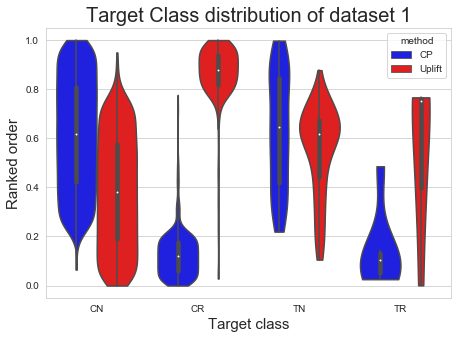

In [48]:
#churn prediction method
churn_target_class = df_data_churn_all.copy()
churn_target_class = churn_target_class.reset_index()
churn_target_class.target_class.replace([0, 1, 2, 3], ['CN', 'CR', 'TN', 'TR'], inplace = True)
churn_target_class['method'] = 'CP'
#uplift method
uplift_target_class = df_data_uplift_all.copy()
uplift_target_class = uplift_target_class.reset_index()
uplift_target_class.target_class.replace([0, 1, 2, 3], ['CN', 'CR', 'TN', 'TR'], inplace = True)
uplift_target_class['method'] = 'Uplift'
all_method_target_class = pd.concat([churn_target_class, uplift_target_class])
max_index = max(all_method_target_class['index'])
all_method_target_class['index'] = all_method_target_class['index']/max_index
plt.figure(figsize=(15,10))
sns.violinplot(data=all_method_target_class, x='target_class', y='index', hue='method', 
               yticklabels=np.arange(0.1,1.1,0.1), cut=0, palette=['blue','red'],
              order=['CN', 'CR', 'TN', 'TR'])
plt.title('Target Class distribution of dataset 1',fontsize=20)
plt.ylabel('Ranked order',fontsize=15)
plt.xlabel('Target class',fontsize=15)
plt.subplots_adjust(right=0.5)
plt.subplots_adjust(top=0.5)

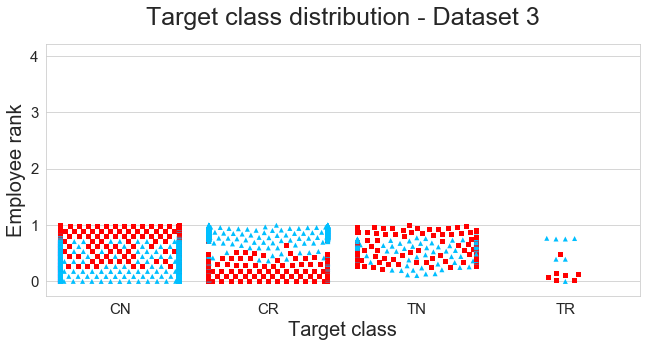

In [49]:
# dummy plots, just to get the Path objects
fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='s')
b = ax.scatter([1,2],[3,4], marker='^')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()


ax = sns.swarmplot(data=all_method_target_class, x='target_class', y='index', 
              hue='method', palette=['red','deepskyblue'], 
                   order=['CN', 'CR', 'TN', 'TR'], size=5, edgecolor = 'black',
                   )
plt.title('Target class distribution - Dataset 3',fontsize=25, y=1.05)
plt.ylabel('Employee rank',fontsize=20)
plt.xlabel('Target class',fontsize=20)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1)

# plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.tick_params(labelsize=15)

collections = ax.collections
unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
markers = [triangle_up_mk, square_mk]  # this array must be at least as large as the number of unique colors
for collection in collections:
    paths = []
    for current_color in collection.get_facecolors():
        for possible_marker,possible_color in zip(markers, unique_colors):
            if np.array_equal(current_color,possible_color):
                paths.append(possible_marker)
                break
    collection.set_paths(paths)
#update legend
ax.legend_.remove()
# ax.legend(collections[-2:],pd.unique(all_method_target_class.method))  

In [50]:
#store dataset to be used globally
dataset_1 = all_method_target_class
%store dataset_1

Stored 'dataset_1' (DataFrame)


In [51]:
#measure the train data
train_description = pd.Series()
train_description['train_size'] = [len(X_train)]
train_description['train_treatment_response_rate'] = [(round(sum(X_train['target_class'] == 3) /sum(X_train[treat]),4))]
train_description['train_control_response_rate'] = [(round(sum(X_train['target_class'] == 1) /sum(X_train[treat]==0),4))]
#measure the test data
test_description = pd.Series()
test_description['test_size'] = [len(X_test)]
test_description['test_treatment_response_rate'] = [round(sum(X_test['target_class'] == 3) /sum(X_test[treat]),4)]
test_description['test_control_response_rate'] = [round(sum(X_test['target_class'] == 1) /sum(X_test[treat]==0),4)]
#print the result
print(train_description)
print(test_description)

train_size                        [10499]
train_treatment_response_rate    [0.0538]
train_control_response_rate      [0.2428]
dtype: object
test_size                         [4500]
test_treatment_response_rate    [0.0729]
test_control_response_rate        [0.24]
dtype: object


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


<h2>EMP

In [52]:
CN, TN, C, T = sum((df_model[treat] == 0)&(df_model['Stay'] == 0)), sum((df_model[treat] == 1)&(df_model['Stay'] == 0)), sum(df_model[treat] == 0), sum(df_model[treat] == 1)
mu_CN = CN/C
mu_CR = 1 - mu_CN
mu_TN = TN/T
mu_TR = 1 - mu_TN

In [53]:
#define basic variable c=cost, j=decile_count
k=10
#set decile step/10 or /100
j=round(len(df_data_churn_all)/10)
#prepare 3 dataframe for CPMP
EMP_C = pd.DataFrame({"n":[], 
                      "emp":[]})
EMP_U = EMP_C.copy()
b=100
i_cost=5
d=0
A=0

C_list, U_list = [], []

for i in range(k):
    m=(i+1)*j
    m_max = j*k
    
    #alpha:
    CN_c = sum(df_data_churn_all.target_class[0:m]==0)
    CR_c = sum(df_data_churn_all.target_class[0:m]==1)
    TN_c = sum(df_data_churn_all.target_class[0:m]==2)
    TR_c = sum(df_data_churn_all.target_class[0:m]==3)
            
    CN_u = sum(df_data_uplift_all.target_class[0:m]==0)
    CR_u = sum(df_data_uplift_all.target_class[0:m]==1)
    TN_u = sum(df_data_uplift_all.target_class[0:m]==2)
    TR_u = sum(df_data_uplift_all.target_class[0:m]==3)
            
    CNTN_c= (CN_c*mu_TN) + (TN_c*mu_CN)
    CNTR_c= (CN_c*mu_TR) + (TR_c*mu_CN)
    CRTN_c= (CR_c*mu_TN) + (TN_c*mu_CR)
    CRTR_c= (CR_c*mu_TR) + (TR_c*mu_CR)
    
    CNTN_u= (CN_u*mu_TN) + (TN_u*mu_CN)
    CNTR_u= (CN_u*mu_TR) + (TR_u*mu_CN)
    CRTN_u= (CR_u*mu_TN) + (TN_u*mu_CR)
    CRTR_u= (CR_u*mu_TR) + (TR_u*mu_CR)
    
    #1-alpha:
    CN_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==0)
    CR_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==1)
    TN_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==2)
    TR_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==3)
            
    CN_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==0)
    CR_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==1)
    TN_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==2)
    TR_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==3)
            
    CNTN_c_2= (CN_c_2*mu_TN) + (TN_c_2*mu_CN)
    CNTR_c_2= (CN_c_2*mu_TR) + (TR_c_2*mu_CN)
    CRTN_c_2= (CR_c_2*mu_TN) + (TN_c_2*mu_CR)
    CRTR_c_2= (CR_c_2*mu_TR) + (TR_c_2*mu_CR)
    
    CNTN_u_2= (CN_u_2*mu_TN) + (TN_u_2*mu_CN)
    CNTR_u_2= (CN_u_2*mu_TR) + (TR_u_2*mu_CN)
    CRTN_u_2= (CR_u_2*mu_TN) + (TN_u_2*mu_CR)
    CRTR_u_2= (CR_u_2*mu_TR) + (TR_u_2*mu_CR)
         
    #churn Estimated  Maximum Profit
    emp_c = (CNTR_c*(b-i_cost-d)+CNTN_c*(-d)+CRTR_c*(-i_cost-d)+CRTN_c*(-b-d)) + (CRTN_c_2*(b)+CNTR_c_2*(-b))
    #Churn Uplift Estimated Maximum Profit
    emp_u = (CNTR_u*(b-i_cost-d)+CNTN_u*(-d)+CRTR_u*(-i_cost-d)+CRTN_u*(-b-d)) + (CRTN_u_2*(b)+CNTR_u_2*(-b))
#     #churn Estimated  Maximum Profit
#     emp_c = (CRTN_c*(b-i_cost-d)+CNTN_c*(-d)+CRTR_c*(-i_cost-d)+CNTR_c*(-b-d)) 
#     #Churn Uplift Estimated Maximum Profit
#     emp_u = (CRTN_u*(b-i_cost-d)+CNTN_u*(-d)+CRTR_u*(-i_cost-d)+CNTR_u*(-b-d))  
    
    
    C_list.append(pd.Series([((i+1)/10),emp_c], index=EMP_C.columns)) 
    U_list.append(pd.Series([((i+1)/10),emp_u], index=EMP_U.columns))
    
EMP_C = EMP_C.append(C_list , ignore_index=True)
EMP_U = EMP_U.append(U_list , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'emp':0}, index =[0])
EMPC = pd.concat([q0, EMP_C]).reset_index(drop = True)
EMPU = pd.concat([q0, EMP_U]).reset_index(drop = True)

In [54]:
#create new column method = churn_prediction
EMPC['method'] = 'CP'

#create new column method = uplift_modelling Prediction
EMPU['method'] = 'Uplift'

#Combine both Churn Prediction and uplift modelling result
result_emp = pd.concat([EMPU, EMPC])
result_emp = result_emp.sort_values(by='n')
result_emp

,n,emp,method
0,0.0,0.000000,Uplift
0,0.0,0.000000,CP
1,0.1,84859.551135,Uplift
1,0.1,-2570.462447,CP
2,0.2,89125.999419,Uplift
2,0.2,-85738.993790,CP
3,0.3,92792.447704,Uplift
3,0.3,-104732.552296,CP
4,0.4,95808.868825,Uplift
4,0.4,-104646.158337,CP


In [55]:
#store dataset to be used globally
result_emp_1 = result_emp
%store result_emp_1

Stored 'result_emp_1' (DataFrame)


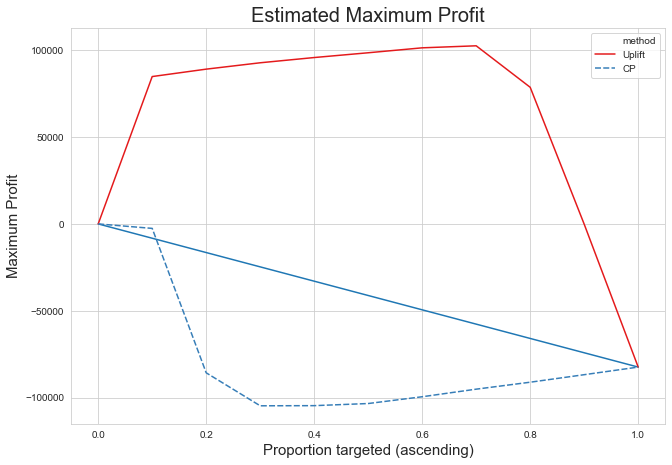

In [56]:
random = np.linspace(EMPC['emp'][0],EMPC['emp'][k],k+1)
sns.lineplot(x=EMPC.n, y=random)
sns.lineplot(x='n', y='emp', hue='method', data=result_emp, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Estimated Maximum Profit',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2> MPU

In [57]:
#define basic variable c=cost, j=decile_count
c=0
j=round(len(df_data_churn_all)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "mp":[]})
CUMP1 = CPMP1.copy()

#1
b1=82000
i1=16666
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)

CP_list1, CU_list1 = [], []

for i in range(10):
    m=(i+1)*j
    
         
    #Variables for churn Prediction 
    #retained within the segment
    r = sum(df_data_churn_all.target_class[0:m]==3)
    #not retained within the segment
    nr =  sum(df_data_churn_all.target_class[0:m]==2)
    #False retained within the segment
    fr = sum(df_data_churn_all.target_class[0:m]==1)
        
    #Variables for Uplift Modelling
    u_r=sum(df_data_uplift_all.target_class[0:m]==3)
    u_nr=sum(df_data_uplift_all.target_class[0:m]==2)
    u_fr=sum(df_data_uplift_all.target_class[0:m]==1)
    
    
    #Churn Prediction mp 
    #r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    #churn Maximum Profit
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/m
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    #Churn Uplift Maximum Profit
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/m
    
    
    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr, mp1], index=CPMP1.columns)) 
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp1], index=CUMP1.columns))
    

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mp':0}, index =[0])
CPMP1 = pd.concat([q0, CPMP1]).reset_index(drop = True)

CUMP1 = pd.concat([q0, CUMP1]).reset_index(drop = True)

In [58]:
#create new column method = churn_prediction
CPMP1['method'] = 'MPC'
#create new column method = uplift_modelling Prediction
CUMP1['method'] = 'MPU'
#Combine both Churn Prediction and uplift modelling result
result_mp1 = pd.concat([CUMP1, CPMP1])
result_mp1 = result_mp1.sort_values(by='n')
result_mp1

,n,mp,retained,non_retained,false,method
0,0.0,0.000000,NaN,NaN,NaN,MPU
0,0.0,0.000000,NaN,NaN,NaN,MPC
1,0.1,-151.097778,1.0,0.0,8.0,MPU
1,0.1,-16082.297778,3.0,0.0,446.0,MPC
2,0.2,-131.102222,1.0,6.0,11.0,MPU
2,0.2,-16045.262222,6.0,0.0,890.0,MPC
3,0.3,-161.472593,1.0,12.0,17.0,MPU
3,0.3,-12165.918519,6.0,7.0,1009.0,MPC
4,0.4,-141.100000,3.0,20.0,27.0,MPU
4,0.4,-9328.134444,6.0,21.0,1031.0,MPC


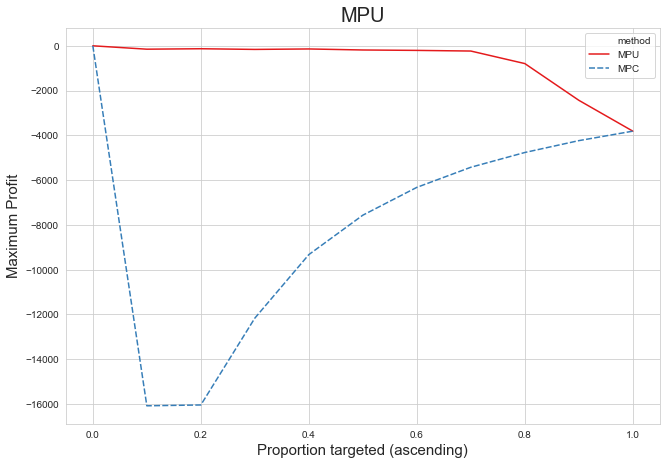

In [59]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp1, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('MPU',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Mean Population of each Target Class (mu)

In [60]:
(df_data_churn_all.target_class[0:m]==3)

0       False
1       False
2       False
3       False
4       False
        ...  
4495    False
4496    False
4497    False
4498    False
4499    False
Name: target_class, Length: 4500, dtype: bool

In [61]:
sum(df_data_churn_all.target_class[0:m]==3)

7

In [62]:
#define basic variable c=cost, j=decile_count
#if Salary = 50.000 and 5% of payrise, c = 0
c=0
j=round(len(df_data_churn_all)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "mp":[]})
CUMP1 = CPMP1.copy()

#1
b1=83
i1=2.5
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)

CP_list1, CU_list1 = [], []

for i in range(10):
    m=(i+1)*j
    
         
    #Variables for churn Prediction 
    #retained within the segment
    r = sum(df_data_churn_all.target_class[0:m]==3)
    #not retained within the segment
    nr =  sum(df_data_churn_all.target_class[0:m]==2)
    #False retained within the segment
    fr = sum(df_data_churn_all.target_class[0:m]==1)
        
    #Variables for Uplift Modelling
    u_r=sum(df_data_uplift_all.target_class[0:m]==3)
    u_nr=sum(df_data_uplift_all.target_class[0:m]==2)
    u_fr=sum(df_data_uplift_all.target_class[0:m]==1)
    
    
    #Churn Prediction mp 
    #r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    #churn Maximum Profit
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/m
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    #Churn Uplift Maximum Profit
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/m
    
    
    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr, mp1], index=CPMP1.columns)) 
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp1], index=CUMP1.columns))
    

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mp':0}, index =[0])
CPMP1 = pd.concat([q0, CPMP1]).reset_index(drop = True)

CUMP1 = pd.concat([q0, CUMP1]).reset_index(drop = True)

In [63]:
#create new column method = churn_prediction
CPMP1['method'] = 'MPC'
#create new column method = uplift_modelling Prediction
CUMP1['method'] = 'MPU'
#Combine both Churn Prediction and uplift modelling result
result_mp1 = pd.concat([CUMP1, CPMP1])
result_mp1 = result_mp1.sort_values(by='n')
result_mp1

,n,mp,retained,non_retained,false,method
0,0.0,0.000000,NaN,NaN,NaN,MPU
0,0.0,0.000000,NaN,NaN,NaN,MPC
1,0.1,0.134444,1.0,0.0,8.0,MPU
1,0.1,-1.941111,3.0,0.0,446.0,MPC
2,0.2,0.058889,1.0,6.0,11.0,MPU
2,0.2,-1.935556,6.0,0.0,890.0,MPC
3,0.3,0.028148,1.0,12.0,17.0,MPU
3,0.3,-1.510741,6.0,7.0,1009.0,MPC
4,0.4,0.096667,3.0,20.0,27.0,MPU
4,0.4,-1.163611,6.0,21.0,1031.0,MPC


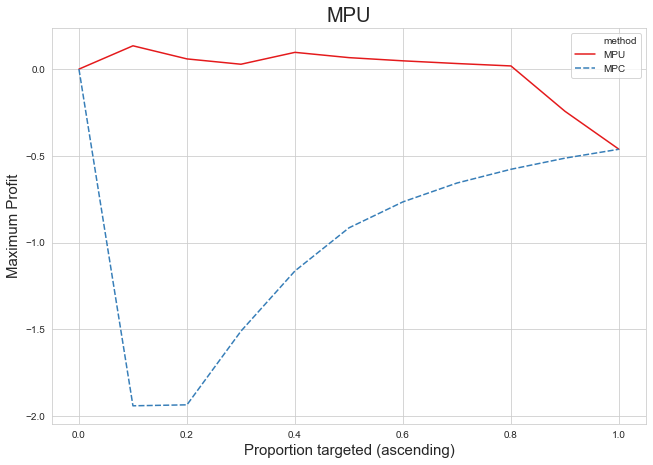

In [64]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp1, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('MPU',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Treatment and Control

In [101]:
#prepare 3 dataframe for CPMPU
CPMPU = pd.DataFrame({"n":[], 
                      "QINI":[], 
                      "TR":[],  
                      "mpu":[]})
CUMPU, PUMPU = CPMPU.copy(), CPMPU.copy()
CP_list, CU_list, PU_list = [], [], []

#prepare dataframe for QINI Curves
QU = pd.DataFrame({"n":[],  
                    "uplift":[]})
QC = QU.copy()
QP = QU.copy()
QU_list, QC_list, QP_list = [], [], []
p4_1=(b1-i1)

j = 10
k = math.ceil(len(df_data_churn_all)/j)
for i in range(j):
    m=(i+1)*k 
    
#     #Input total actual control and treatment data
    churn_control_count = sum(df_data_churn_all[treat]==0)
    churn_treatment_count = sum(df_data_churn_all[treat]==1)
#     #Input total actual control and treatment data
    uplift_control_count = sum(df_data_uplift_all[treat]==0)
    uplift_treatment_count = sum(df_data_uplift_all[treat]==1)
    #Actual Qini Churn - Input Data
    RC_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==0))
    RT_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==1))
    NC_churn = sum(df_data_churn_all[treat][0:m]==0)
    NT_churn = sum(df_data_churn_all[treat][0:m]==1)
    #Actual Qini Uplift - Input Data
    RC_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==0))
    RT_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==1))
    NC_uplift = sum(df_data_uplift_all[treat][0:m]==0)
    NT_uplift = sum(df_data_uplift_all[treat][0:m]==1)
    #Predicted Qini Uplift - Input Data
    RC_predicted = sum(df_data_uplift_all.p_target[0:m]==1)
    RT_predicted = sum(df_data_uplift_all.p_target[0:m]==3)
    NC_predicted = sum(df_data_uplift_all.p_target[0:m]<=1)
    NT_predicted = sum(df_data_uplift_all.p_target[0:m]>=2)
    
#     pilih salah satu metode:    
    QINI_c = ((RT_churn/churn_treatment_count) - (RC_churn/churn_control_count))
    QINI_u = ((RT_uplift/uplift_treatment_count) - (RC_uplift/uplift_control_count))   
    #Calculate QINI
#     QINI_c = (RT_churn-((RC_churn*NT_churn)/NC_churn))
#     QINI_u = (RT_uplift-((RC_uplift*NT_uplift)/NC_uplift))
    QINI_p = (RT_predicted/2-((RC_predicted*NT_predicted)/NC_predicted)*2)
    #Append to list
    QC_list.append(pd.Series([((i+1)/10), QINI_c], index=QC.columns))
    QU_list.append(pd.Series([((i+1)/10), QINI_u], index=QU.columns))
    QP_list.append(pd.Series([((i+1)/10), QINI_p], index=QU.columns))
    
    #Calculate MPU 
    #TR
    TR_churn=sum(df_data_churn_all.target_class[0:m] == 3)
    TR_uplift=sum(df_data_uplift_all.target_class[0:m] == 3) 
    #Qini & TR for churn prediction
    CP_profit = ((QINI_c*p4_1) - TR_churn)/m
    #Qini & TR for uplift prediction
    CU_profit = ((QINI_u*p4_1) - TR_uplift)/m
    #Qini & TR for uplift prediction
    PU_profit = ((QINI_p*p4_1) - RT_predicted)/m
    #Append to list
    CP_list.append(pd.Series([((i+1)/10), QINI_c, TR_churn, CP_profit], index=CPMPU.columns))  
    CU_list.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, CU_profit], index=CUMPU.columns))
    PU_list.append(pd.Series([((i+1)/10), QINI_p, RT_predicted, PU_profit], index=CUMPU.columns))
    
    
# append list into dataframe    
QU = QU.append(QU_list , ignore_index=True)
QC = QC.append(QC_list , ignore_index=True)
QP = QP.append(QP_list , ignore_index=True)
# add q0 into dataframe for Qini Curve
q0 = pd.DataFrame({'n':0, 'uplift':0}, index =[0])
QU = pd.concat([q0, QU]).reset_index(drop = True)
QC = pd.concat([q0, QC]).reset_index(drop = True)
QP = pd.concat([q0, QP]).reset_index(drop = True)

# append MPU list into dataframe    
CPMPU = CPMPU.append(CP_list , ignore_index=True)
CUMPU = CUMPU.append(CU_list , ignore_index=True)
PUMPU = PUMPU.append(PU_list , ignore_index=True)
# add q0 into MPU dataframe
q0 = pd.DataFrame({'n':0, 'mpu':0}, index =[0])
CPMPU = pd.concat([q0, CPMPU]).reset_index(drop = True)
CUMPU = pd.concat([q0, CUMPU]).reset_index(drop = True)
PUMPU = pd.concat([q0, PUMPU]).reset_index(drop = True)

In [66]:
CPMPU['Churn Prediction MPU'] = CPMPU['mpu']
CPMPU['Uplift Prediction MPU'] = CUMPU['mpu']
CPMPU['Predicted Uplift MPU'] = PUMPU['mpu'] 
CPMPU = CPMPU.drop(['mpu', 'QINI', 'TR'], axis=1)
CPMPU

,n,Churn Prediction MPU,Uplift Prediction MPU,Predicted Uplift MPU
0,0.0,0.000000,0.000000,0.000000
1,0.1,-0.005466,0.173479,0.000000
2,0.2,-0.004265,0.080621,0.000000
3,0.3,-0.231679,0.049032,0.000000
4,0.4,-0.437162,0.116871,0.000000
5,0.5,-0.380160,0.087506,0.000000
6,0.6,-0.373630,0.066107,0.000000
7,0.7,-0.345858,0.040809,-0.000814
8,0.8,-0.293645,0.033974,-0.024700
9,0.9,-0.296761,-0.161314,-0.085417


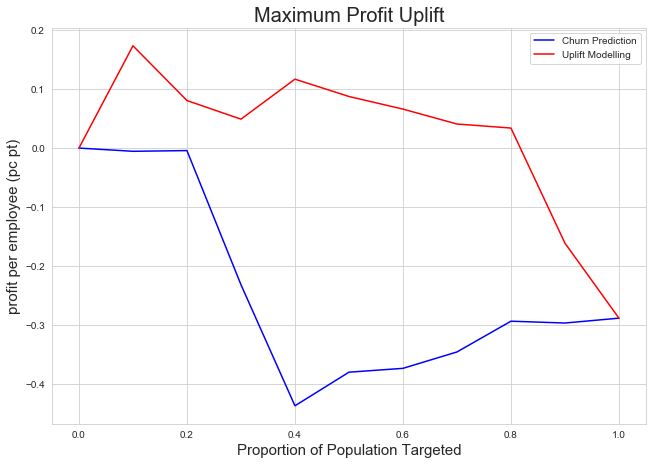

In [67]:
sns.lineplot(x=CPMPU.n, y=CPMPU['Churn Prediction MPU'], label='Churn Prediction', color='blue')
sns.lineplot(x=CPMPU.n, y=CPMPU['Uplift Prediction MPU'], label='Uplift Modelling', color='red')
# sns.lineplot(x=CPMPU.n, y=CPMPU['Predicted Uplift MPU'], label='Predicted Uplift Modelling', color='green')

sns.set_style("whitegrid")
plt.title('Maximum Profit Uplift',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

In [99]:
QP = QP.rename(columns={"uplift": "Predicted Uplift QINI"})
QP['Actual Uplift QINI'] = QU['uplift']
QP['Actual Churn QINI'] = QC['uplift']
QP

,n,Predicted Uplift QINI,Actual Uplift QINI,Actual Churn QINI
0,0.0,0.000000,0.000000,0.000000
1,0.1,0.000000,-0.070022,-0.070022
2,0.2,0.000000,-0.139589,-0.139589
3,0.3,0.000000,-0.166610,-0.166610
4,0.4,0.000000,-0.171605,-0.171605
5,0.5,0.000000,-0.165276,-0.165276
6,0.6,0.000000,-0.165957,-0.165957
7,0.7,-0.031847,-0.166184,-0.166184
8,0.8,-1.104603,-0.167092,-0.167092
9,0.9,-4.297398,-0.167092,-0.167092


In [102]:
#create new column method = churn_prediction
QC['method'] = 'CP'

#create new column method = uplift_modelling Prediction
QU['method'] = 'Uplift'

#Combine both Churn Prediction and uplift modelling result
result_QINI = pd.concat([QC, QU])
result_QINI = result_QINI.sort_values(by='n')
result_QINI

,n,uplift,method
0,0.0,0.000000,CP
0,0.0,0.000000,Uplift
1,0.1,-0.070022,CP
1,0.1,0.008600,Uplift
2,0.2,-0.139589,CP
2,0.2,0.007919,Uplift
3,0.3,-0.166610,CP
3,0.3,0.006557,Uplift
4,0.4,-0.171605,CP
4,0.4,0.025119,Uplift


In [103]:
#store dataset to be used globally
result_QINI_1 = result_QINI
%store result_QINI_1

Stored 'result_QINI_1' (DataFrame)


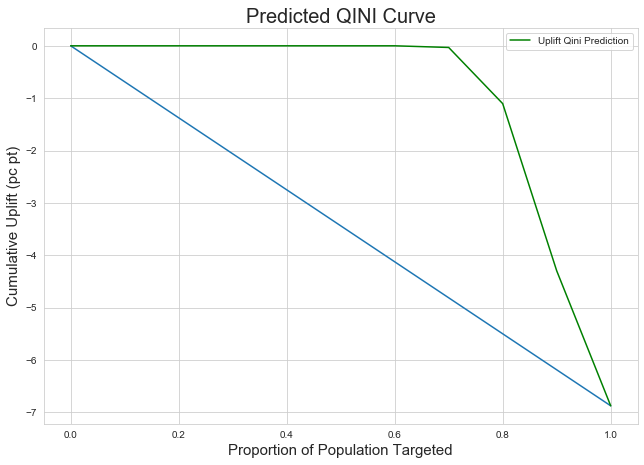

In [71]:
random = np.linspace(QP['Predicted Uplift QINI'][0],QP['Predicted Uplift QINI'][j],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=QP.n, y=QP['Predicted Uplift QINI'], label="Uplift Qini Prediction", color="green")
sns.set_style("whitegrid")
plt.title('Predicted QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

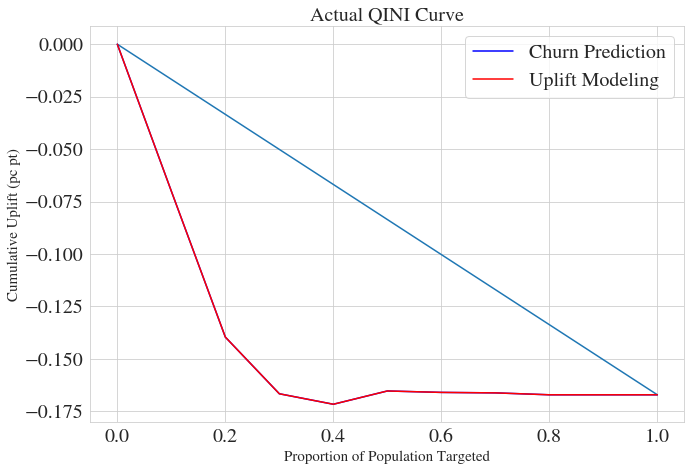

In [100]:
random = np.linspace(QP['Actual Uplift QINI'][0],QP['Actual Uplift QINI'][10],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=QC.n, y=QC.uplift, label="Churn Prediction", color="blue")
sns.lineplot(x=QU.n, y=QU.uplift, label="Uplift Modeling", color="red")
sns.set_style("whitegrid")
plt.title('Actual QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

<h2>Pylift

In [73]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Stay,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,target_class
id,,,,,,,,,,,,,,,,,,,,
0,0.38,0.53,2,157,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
1,0.80,0.86,5,262,6,0,1,0,2,0,0,0,0,0,0,0,1,0,0,1
2,0.11,0.88,7,272,4,0,1,0,2,0,0,0,0,0,0,0,1,0,0,1
3,0.72,0.87,5,223,5,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
4,0.37,0.52,2,159,3,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1
14995,0.37,0.48,2,160,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1
14996,0.37,0.53,2,143,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1


pylift modelling

In [74]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [75]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   45.4s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.5min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=1,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                                      16, 17, 18, 19, 20],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                  

In [76]:
up.fit(**up.rand_search_.best_params_)

[20:06:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.


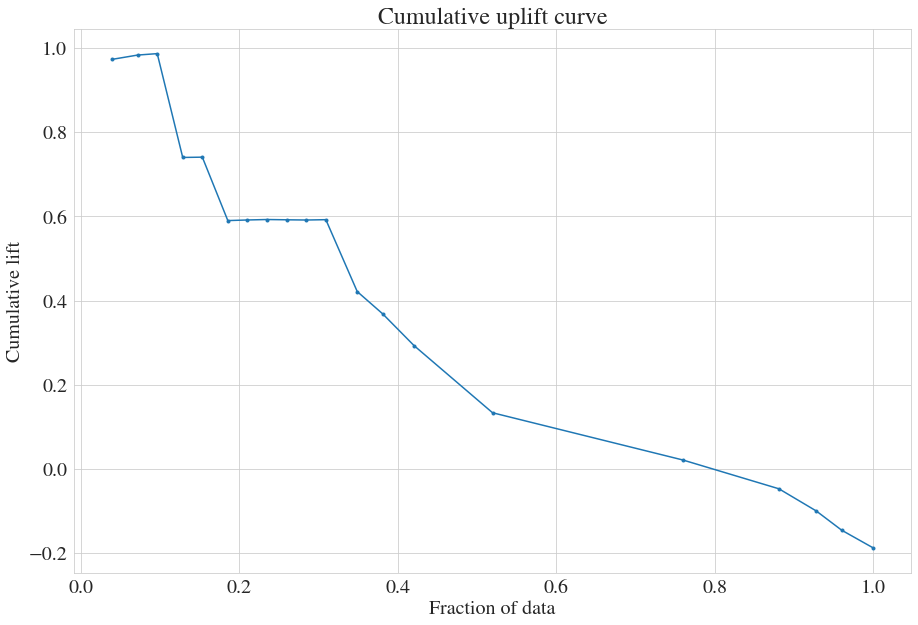

In [77]:
up.plot(plot_type='cuplift')

In [78]:
up.test_results_.q1_cgains

1.1824352689781574

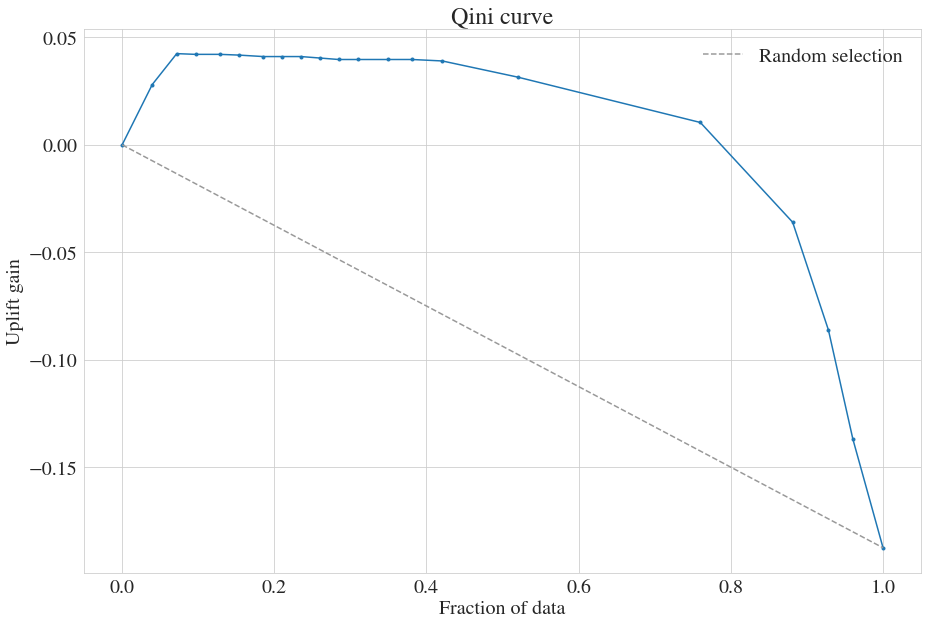

In [79]:
up.plot(plot_type='qini')

[20:06:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 0 finished.
[20:06:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 1 finished.
[20:06:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 2 finished.
[20:06:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Seed 3 finished.
[20:06:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Seed 4 finished.


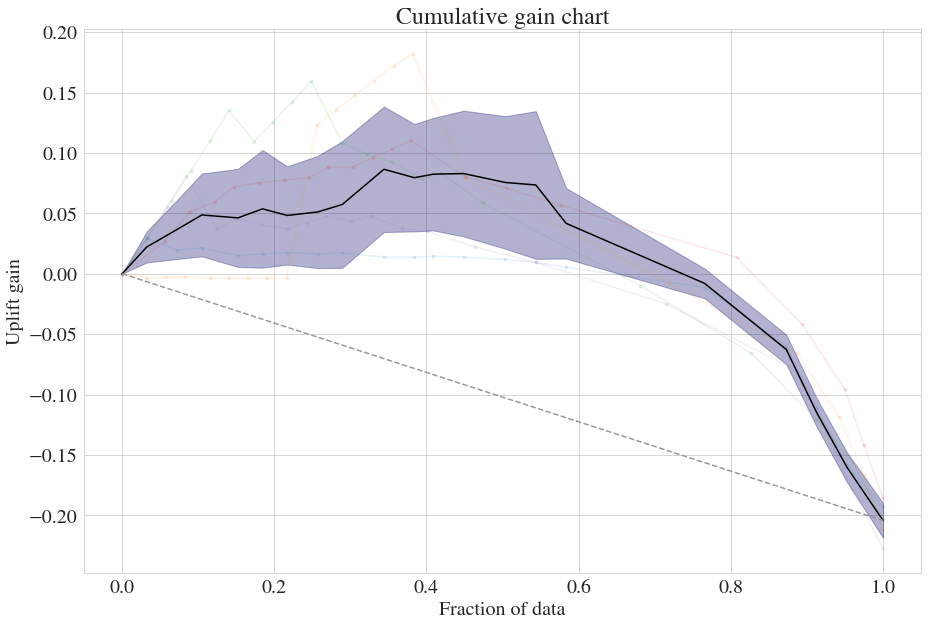

In [80]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

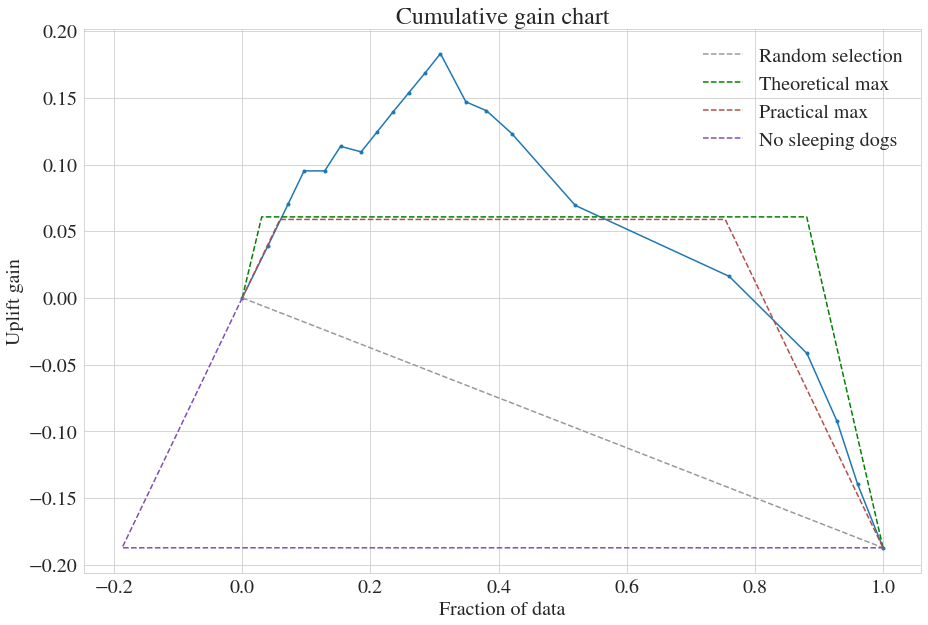

In [81]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [82]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [83]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,1,0,0,0.000000,1,16.666667,0.6,0.6,10.0,1,0.000000
1,1,1,1,16.666667,2,33.333333,0.6,1.2,20.0,1,0.833333
2,1,1,2,33.333333,3,50.000000,0.6,1.8,30.0,1,1.111111
3,1,1,3,50.000000,4,66.666667,0.6,2.4,40.0,1,1.250000
4,1,1,4,66.666667,5,83.333333,0.6,3.0,50.0,1,1.333333
5,1,1,5,83.333333,6,100.000000,0.6,3.6,60.0,1,1.388889
6,1,1,6,100.000000,7,100.000000,0.6,4.2,70.0,1,1.428571
7,0,0,6,100.000000,7,100.000000,0.6,4.8,80.0,1,1.250000
8,0,0,6,100.000000,7,100.000000,0.6,5.4,90.0,1,1.111111
9,0,0,6,100.000000,7,100.000000,0.6,6.0,100.0,1,1.000000


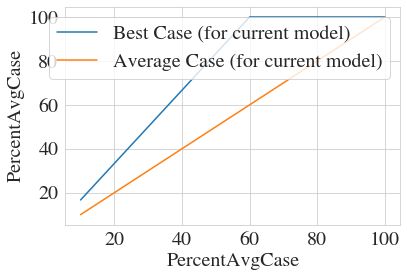

In [84]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

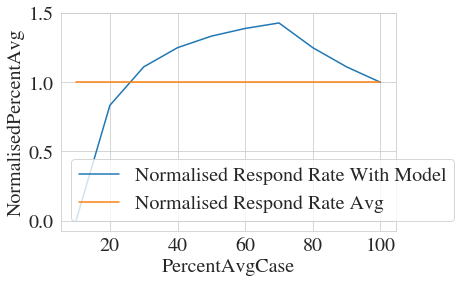

In [85]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [86]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in longlong_scalars
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


,NumCases,NumCorrectPredictions,RunningCorrect,PercentCorrect,CumulativeCorrectBestCase,PercentCorrectBestCase,AvgCase,CumulativeAvgCase,PercentAvgCase,NormalisedPercentAvg,NormalisedPercentWithModel
0,1,0,0,NaN,1,100,0.0,0.0,NaN,1,NaN
1,1,0,0,NaN,2,100,0.0,0.0,NaN,1,NaN
2,1,0,0,NaN,3,100,0.0,0.0,NaN,1,NaN
3,1,0,0,NaN,4,100,0.0,0.0,NaN,1,NaN
4,1,0,0,NaN,5,100,0.0,0.0,NaN,1,NaN
5,1,0,0,NaN,6,100,0.0,0.0,NaN,1,NaN
6,1,0,0,NaN,7,100,0.0,0.0,NaN,1,NaN
7,0,0,0,NaN,7,100,0.0,0.0,NaN,1,NaN
8,0,0,0,NaN,7,100,0.0,0.0,NaN,1,NaN
9,0,0,0,NaN,7,100,0.0,0.0,NaN,1,NaN


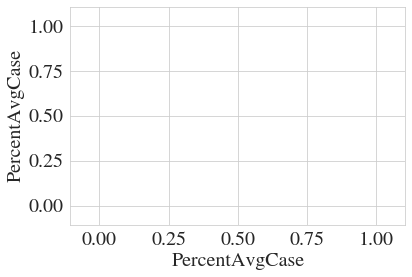

In [87]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

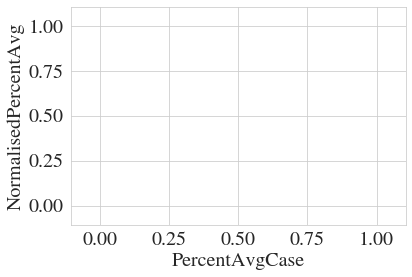

In [88]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [89]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

KeyError: "['p_stay' 'p_target'] not found in axis"

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df